In [ ]:
# Importation des bibliothèques
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import time

In [ ]:
# Set up de google drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip les dataset dans /tmp
!unzip -q "/content/drive/MyDrive/IA201/cancer.zip" -d "/tmp/cancer"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /tmp/cancer/test/Benign/6299.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Image transforms for ResNet
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

melanoma_train_path = "/tmp/cancer/train"
melanoma_test_path = "/tmp/cancer/test"

melanoma_train_dataset =  torchvision.datasets.ImageFolder(melanoma_train_path, transform=transform)
melanoma_test_dataset =  torchvision.datasets.ImageFolder(melanoma_test_path, transform=transform)

#define GPU as device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


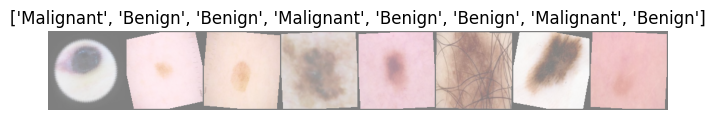

In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = 8

# Création du loader
melanoma_train_loader = DataLoader(melanoma_train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, pin_memory=True, persistent_workers=True)

# Affichage d'un mini-batch
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

dataiter = iter(melanoma_train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]), title=[melanoma_train_dataset.classes[i] for i in labels[:8]])

In [ ]:
# CNN Simple reprit de la documentation Pytorch
class NeuralNetwork(nn.Module):
  def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.dropout = nn.Dropout(0.5)

        # Taille des features maps après 4x MaxPool(2,2) (128 -> 64 -> 32 -> 16 -> 8)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 2)

  def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 128x128 -> 64x64
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 64x64 -> 32x32
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # 16x16 -> 8x8
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

[1,    50] loss: 0.839
Batch 49 time: 4.00s
[1,   100] loss: 0.395
Batch 99 time: 5.39s
[1,   150] loss: 0.372
Batch 149 time: 4.55s
→ Accuracy après epoch 1: 81.06%
Epoch time: 17.33s
[2,    50] loss: 0.356
Batch 49 time: 4.19s
[2,   100] loss: 0.359
Batch 99 time: 5.60s
[2,   150] loss: 0.346
Batch 149 time: 3.79s
→ Accuracy après epoch 2: 84.78%
Epoch time: 17.12s
[3,    50] loss: 0.342
Batch 49 time: 5.76s
[3,   100] loss: 0.320
Batch 99 time: 4.00s
[3,   150] loss: 0.339
Batch 149 time: 3.99s
→ Accuracy après epoch 3: 85.60%
Epoch time: 17.91s
[4,    50] loss: 0.325
Batch 49 time: 4.22s
[4,   100] loss: 0.315
Batch 99 time: 4.09s
[4,   150] loss: 0.319
Batch 149 time: 5.26s
→ Accuracy après epoch 4: 86.49%
Epoch time: 17.81s
[5,    50] loss: 0.324
Batch 49 time: 4.05s
[5,   100] loss: 0.300
Batch 99 time: 4.39s
[5,   150] loss: 0.311
Batch 149 time: 7.12s
→ Accuracy après epoch 5: 86.78%
Epoch time: 18.71s
[6,    50] loss: 0.294
Batch 49 time: 3.95s
[6,   100] loss: 0.307
Batch 99

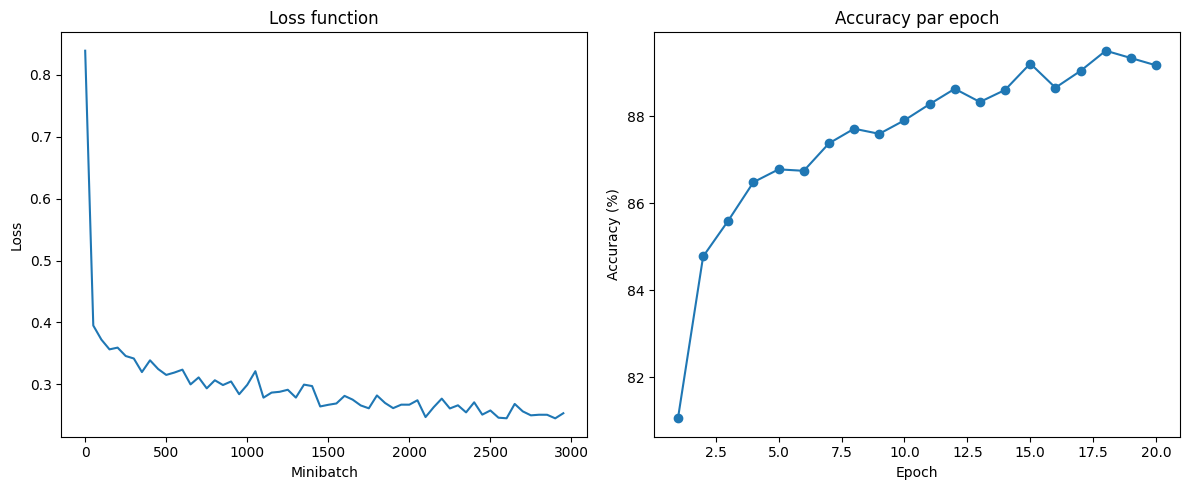

In [ ]:
net = NeuralNetwork().to(device)  # Assure-toi que le modèle est sur le bon device

# Définir le loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.0005, betas=(0.9, 0.999))

# Entraînement
loss_list = []
loss_list_idx = []
acc_list = []
compteur = 0

for epoch in range(20):
    running_loss = 0.0
    correct = 0
    total = 0
    start = time.time()

    net.train()  # Mode entraînement

    batch_start = time.time()

    for i, data in enumerate(melanoma_train_loader, 0):
        if i % 50 == 0:
          batch_start = time.time()

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Prédictions pour l'accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 50 == 49:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/50:.3f}')
            print(f"Batch {i} time: {time.time() - batch_start:.2f}s")
            loss_list.append(running_loss / 50)
            loss_list_idx.append(compteur * 50)
            running_loss = 0.0
            compteur += 1

    # Accuracy à la fin de l’époque
    epoch_acc = 100 * correct / total
    acc_list.append(epoch_acc)
    print(f'→ Accuracy après epoch {epoch + 1}: {epoch_acc:.2f}%')
    print(f"Epoch time: {time.time() - start:.2f}s")

print('Finished Training')

# Affichage des courbes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_list_idx, loss_list)
plt.title("Loss function")
plt.xlabel("Minibatch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(acc_list) + 1), acc_list, marker='o')
plt.title("Accuracy par epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()

Accuracy on test set: 90.40%


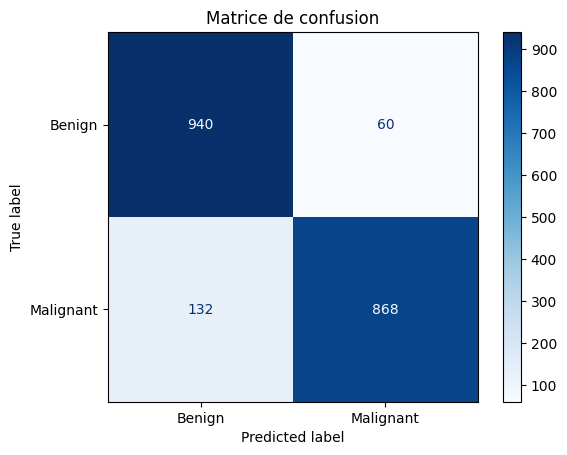

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Passer le modèle en mode évaluation
net.eval()

# Créer un DataLoader pour le test
melanoma_test_loader = DataLoader(melanoma_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Variables pour compter
correct = 0
total = 0

all_preds = []
all_labels = []

# Pas de calcul de gradient
with torch.no_grad():
    for data in melanoma_test_loader:
        images, labels = data

        # Déplacement vers le bon device
        images, labels = images.to(device), labels.to(device)

        # Prédiction
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Sauvegarde des prédictions pour matrice de confusion
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Affichage de l'accuracy
print(f'Accuracy on test set: {100 * correct / total:.2f}%')

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=melanoma_test_dataset.classes)

# Affichage
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()
